<center><font size=5><b>Extracting harmonics of $\phi$-dependent data in Gepard</b></font></center>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import gepard as g

In [3]:
import gdevel as gd
print(gd.__version__)

0.9.11


In [4]:
import os
import subprocess
branch = subprocess.check_output(['git', '-C', os.path.dirname(gd.__file__),
                                  'branch', '--show-current']).decode('ascii').strip()
revhash = subprocess.check_output(['git', '-C', os.path.dirname(gd.__file__),
                                   'rev-parse', 'HEAD']).decode('ascii').strip()
print('Current git branch is "{}" and revision hash is {}'.format(branch, revhash))

Current git branch is "devel" and revision hash is 6a29f18c7246e4172fd8540814631d1b4fdb0f4a


In [5]:
def plotpts(bin1, bin2=None, replica=None):
    """Plot points in bin with errorbars."""
    fig, ax = plt.subplots(1,1, figsize=[6,6])
    ax.errorbar(bin1.phi.values, bin1.val.values, bin1.err.values, color='blue', linestyle='None',
               capsize=3)
    if isinstance(bin2, pd.DataFrame):
        ax.errorbar(bin2.phi.values, bin2.val.values, bin2.err.values, color='red', linestyle='None',
                   capsize=2)
    if isinstance(replica, np.ndarray):
        ax.plot(bin1.phi.values, replica, marker='o', color='red', linestyle='None')
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlim(-np.pi, np.pi)
    fig.savefig('fig')

In [6]:
def plotFT(dfs, cosmax, sinmax):
    """Plot harmonics with with errorbars."""
    CM = cosmax
    SM = sinmax
    fig, ax = plt.subplots(1,1, figsize=[6,6])
    shift = 0
    for df in dfs:
        c = df.val.values[:CM+1]
        delc = df.err.values[:CM+1]
        s = df.val.values[CM+1:CM+SM+1]
        dels = df.err.values[CM+1:CM+SM+1]
        ax.errorbar(np.arange(CM+1)+shift, c, delc, linestyle='None', capsize=3,color='blue')
        ax.errorbar(np.arange(-1,-SM-1,-1)+shift, s, dels, linestyle='None', capsize=3, color='red')
        shift += 0.05
    ax.axhline(linestyle='-.', color='green', linewidth=0.5)
    ax.axvline(linestyle='-.', color='green', linewidth=0.5)
    #ax.legend(loc=4, fontsize=14).draw_frame(1)
    fig.savefig('fig')

## Basic extraction of harmonics (CLAS $A_{\rm LU}$) 

In [7]:
#sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepard/src/gepard/')
sys.path.append('/Users/higuera-admin/Documents/Programs/ldrdgff/gepardDevel/gdevel/src/gdevel')
import mydatafiles
from mydatafiles import ep2epgamma

mydset = gd.data.loaddata(mydatafiles)
mydset.update(gd.data.loaddata(ep2epgamma))

In [8]:
fitpoints = mydset[270] #mydset[191] # mydset[192] 
g.describe_data(fitpoints)

npt x obs     collab  FTn    id  ref.        
----------------------------------------------
117 x BTSA    CLAS    N/A    270 priv comunication
----------------------------------------------
TOTAL = 117


In [9]:
#dfALU = g.dset[139].df()[['Q2', 'xB', 'tm', 'phi', 'val', 'errstat', 'errsyst']]
dfALL = mydset[270].df()[['Q2', 'xB', 'tm', 'phi', 'val', 'errstat', 'errsyst']]

Gepard's FT routines below work with `err` as uncertainty to be FT-transformed. This
should be only statistical uncertainty, while systematic uncertainty should be added
in quadrature after FT (if you don't decide to do some even more sophisticated approach).
Thus we rename column with statistical uncertainties as `err`:

In [10]:
dfALL.rename(columns={'errstat': 'err'}, inplace=True)

Now we detect bins. (This will not work like this if mean values of bin kinematic variables are not exactly the same. In that case you have to write more sophisticated algorithm or define bins manually.)

In [11]:
all_bins = dfALL[['Q2', 'xB', 'tm']].drop_duplicates()
bins = all_bins.reset_index(drop=True)
print('Number of all bins = {}'.format(len(bins)))

Number of all bins = 12


Organize bins in Python directory. (This will include `phi`, `val` and `err` as well.)

In [12]:
binALL = {}
for k in range(len(bins)):
    # binALU[k] = dfALU[np.all(dfALU[['Q2', 'xB', 'tm']] == bins.iloc[k], axis=1)]
    binALL[k] = dfALL[dfALL[['Q2', 'xB', 'tm']].values == bins.iloc[k].values].drop_duplicates()

There is a Gepard function `FTFMC` that will, for given bin, by default extract all harmonics using discrete Fourier transform and Monte Carlo uncertainty propagation.

In [13]:
binALL[4]

,Q2,xB,tm,phi,val,err,errsyst
36,1.62846,0.1084,0.18806,2.956947,0.117650,0.080989,0.0
37,1.62846,0.1084,0.18806,2.658850,0.253484,0.065399,0.0
38,1.62846,0.1084,0.18806,2.405074,0.192774,0.058784,0.0
39,1.62846,0.1084,0.18806,2.152344,0.260911,0.064167,0.0
40,1.62846,0.1084,0.18806,1.898318,0.224466,0.079402,0.0
41,1.62846,0.1084,0.18806,1.351199,0.309001,0.087044,0.0
42,1.62846,0.1084,0.18806,-1.213143,0.216047,0.088857,0.0
43,1.62846,0.1084,0.18806,-1.938834,0.121211,0.082017,0.0
44,1.62846,0.1084,0.18806,-2.191296,0.183222,0.055484,0.0
45,1.62846,0.1084,0.18806,-2.437632,0.273477,0.057138,0.0


In [14]:
dfFT = gd.data.FTFMC(binALL[5])

Be careful. Dataframe that is returned still has `phi` values but they don't make sense here (they are just kept for later cross-check). First (N-1/2) values are cosine harmonics, and rest are sine:

In [15]:
dfFT

,phi,val,err
0,3.006106,-9.113381,10.439743
1,2.757121,-19.063962,18.517838
2,2.503556,-16.685425,13.751681
3,2.230658,-9.373749,7.530195
4,1.551277,-2.468438,1.988220
5,-0.117269,-54.338831,45.212404
6,-2.186810,-73.943672,62.536364
7,-2.483446,-54.937749,47.945244
8,-2.738893,-23.480856,21.577764
9,-3.004183,-4.532309,4.532819


So here above sin($\phi$) harmonic is in row index 5. You can plot all of them:

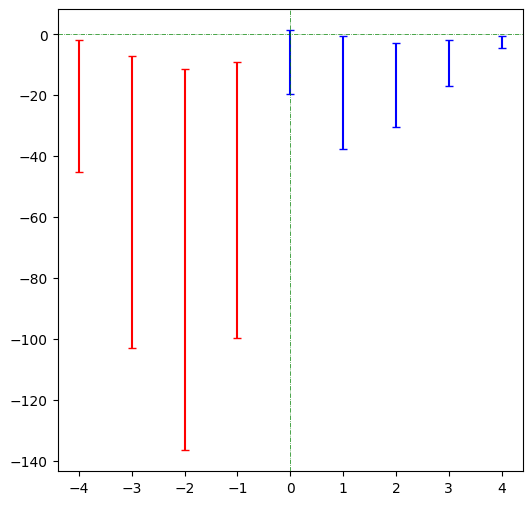

In [16]:
plotFT([dfFT], cosmax=4, sinmax=4)

`FTFMC(df, inverse=True)` will do the inverse FT so you can check the whole procedure for consistency:

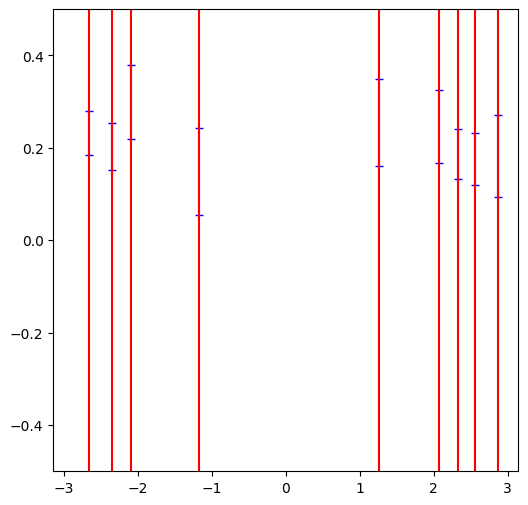

In [17]:
plotpts(binALL[2], gd.data.FTFMC(gd.data.FTFMC(binALL[2]), inverse=True))

There is also a somewhat experimental function `FTanalyse` that can take a set of bins and determine by cross-validation procedure how many harmonics are "visible" in this data:

In [18]:
cosmax, sinmax = gd.data.FTanalyse(binALL)

Highest extractable cos harmonic = 0.583 +- 0.862
Highest extractable sin harmonic = 0.500 +- 0.500



For final harmonic analysis we increase the number of Monte Carlo samples and store the results in two new dataframe columns:

In [19]:
for k in range(len(bins)):
    dfFT = gd.data.FTFMC(binALL[k], nsamples = 3000)
    binALL[k]['FTval'] = pd.Series(dfFT['val'].values, index=binALL[k].index)
    binALL[k]['FTerr'] = pd.Series(dfFT['err'].values, index=binALL[k].index)

In [20]:
binALL[4]

,Q2,xB,tm,phi,val,err,errsyst,FTval,FTerr
36,1.62846,0.1084,0.18806,2.956947,0.117650,0.080989,0.0,27.463443,31.360586
37,1.62846,0.1084,0.18806,2.658850,0.253484,0.065399,0.0,49.476009,56.988672
38,1.62846,0.1084,0.18806,2.405074,0.192774,0.058784,0.0,36.255698,41.954549
39,1.62846,0.1084,0.18806,2.152344,0.260911,0.064167,0.0,20.474800,23.717302
40,1.62846,0.1084,0.18806,1.898318,0.224466,0.079402,0.0,7.960390,9.215140
41,1.62846,0.1084,0.18806,1.351199,0.309001,0.087044,0.0,1.726583,1.912076
42,1.62846,0.1084,0.18806,-1.213143,0.216047,0.088857,0.0,3.056693,2.418610
43,1.62846,0.1084,0.18806,-1.938834,0.121211,0.082017,0.0,4.325158,3.401981
44,1.62846,0.1084,0.18806,-2.191296,0.183222,0.055484,0.0,3.569525,2.802702
45,1.62846,0.1084,0.18806,-2.437632,0.273477,0.057138,0.0,1.888443,1.490557


In [21]:
def s1(bin):
    """Take just first sine harmonic of bin with error."""
    s1ind = int((len(bin)-1)/2.) + 1 # index of first sine harmonic
    return bin[['Q2', 'xB', 'tm', 'FTval', 'FTerr']].iloc[s1ind]

We unite all bins, taking value and uncertainty of just calculated first sine harmonic (FTval and FTerr), and
we also calculate average and maximal systematic error for given bin. One can than choose which of the two
to take as the proper systematic error of the harmonic (more sophisticated treatment could be implemented here by the person who understands systematics better).

In [22]:
FTs1 = pd.DataFrame([pd.concat([s1(binALL[k]),
                                pd.Series([binALL[k]['errsyst'].mean(),
                                                     binALL[k]['errsyst'].max()], index=['avgsyst', 'maxsyst'])])
                     for k in bins.index]).reset_index(drop=True)

This (after maybe some reduction of significant digits) can now be saved into the new Gepard datafile with appropriate preamble:

In [23]:
FTs1['FTval'] = FTs1['FTval'].map(lambda x: '%.3f' % x)
FTs1['FTerr'] = FTs1['FTerr'].map(lambda x: '%.3f' % x)
FTs1['FTerrsyst'] = FTs1['avgsyst'].map(lambda x: '%.3f' % x)   # choose maxsyst to be conservative

In [24]:
print(FTs1[['Q2', 'xB', 'tm', 'FTval', 'FTerr', 'FTerrsyst']].to_string(index=False))

     Q2      xB      tm    FTval  FTerr FTerrsyst
1.70482 0.11924 0.70807   18.130 20.553     0.000
1.92428 0.21290 0.79784   -0.240  0.376     0.000
1.68406 0.11481 0.32030    0.002  0.424     0.000
1.96658 0.18729 0.33239    1.076  4.487     0.000
1.62846 0.10840 0.18806    3.057  2.419     0.000
1.97822 0.15907 0.19850  -47.137 44.917     0.000
2.89131 0.21358 0.85765   17.042 16.934     0.000
4.01413 0.37889 1.05297   -0.343  0.246     0.000
2.70265 0.18294 0.40095   -0.093  0.657     0.000
3.62497 0.29778 0.41792   -7.646  6.155     0.000
2.56688 0.16542 0.22138 -115.313 64.979     0.000
3.26336 0.23598 0.24356   10.126 18.169     0.000


Such procedure was followed to create the mydatafiles ID=182 (some lines are commented out
in that datafile):

In [24]:
print(mydset[182].df()[['Q2', 'xB', 'tm', 'val', 'errstat', 'errsyst']].to_string(index=False))

     Q2      xB      tm    val  errstat  errsyst
1.17098 0.09829 0.29026  0.085    0.039      0.0
1.23055 0.23951 0.34267 -0.885    1.082      0.0
1.16069 0.09807 0.55942  0.156    0.032      0.0
1.20139 0.16075 0.58099  0.004    0.097      0.0
1.22297 0.23502 0.63939  0.229    0.735      0.0
1.16971 0.09702 1.05316  0.766    0.185      0.0
1.60576 0.15599 0.31425 -0.246    0.479      0.0
1.54972 0.11304 0.56128  0.318    0.147      0.0
1.59735 0.16169 0.58224  0.285    0.257      0.0
1.60562 0.25015 0.64407  0.160    0.071      0.0
2.01347 0.14258 0.29988  0.281    0.328      0.0
2.12931 0.19307 0.32879  0.630    0.188      0.0
2.00625 0.14243 0.56632  0.273    0.244      0.0
2.10837 0.19527 0.59712  0.098    0.287      0.0
2.11950 0.31098 0.67478  0.049    0.127      0.0
2.14984 0.29989 1.25910  0.133    0.165      0.0
2.68499 0.18571 0.32106  0.295    0.379      0.0
2.84675 0.25492 0.36339  0.519    0.336      0.0
2.66791 0.18912 0.57114 -0.318    0.657      0.0
2.83258 0.25276 0.63